In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from aldiscore.prediction import utils
from aldiscore import ROOT

In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, *_ = utils.load_features(
    data_dir,
    include_features=["is_dna", "num_seqs", "seq_length"],
)
# feat_df.columns = clean_feat_names
print(feat_df.shape)
feat_df = feat_df[["is_dna", "num_seqs", "max.seq_length"]]
feat_df.head()

Dropping 0 NaN rows...
(11431, 21)


is_dna  num_seqs  max.seq_length
source    dataset                                  
arthropod CYP_12    False       141             558
          CYP_15    False       148             524
          CYP_18    False       124             569
          CYP_2     False        16             544
          CYP_20    False        19             494

In [3]:
perf_dir = ROOT.parent / "logs" / "perf"
perf_file = sorted(os.listdir(perf_dir))[-1]
print(perf_file)
perf_df = pd.read_parquet(perf_dir / perf_file)
# perf_df = pd.concat([perf_df, feat_df], axis=1)
perf_df

2025-10-13_17-00-59.parquet


_init_basics  \
source        dataset                                            
treebase_v1   21420_1.phy                             0.010204   
              14688_14.phy                            0.015336   
              21918_2.phy                             0.016275   
              17890_0.phy                             0.016124   
              15560_1.phy                             0.011913   
...                                                        ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1           0.004451   
              SRP_euk_arch.apsi-43.sci-74.no-1        0.002303   
              Retroviral_psi.apsi-91.sci-76.no-1      0.002047   
              IRES_HCV.apsi-88.sci-67.no-2            0.005284   
              IRES_Picorna.apsi-86.sci-83.no-1        0.002131   

                                                  _init_char_dists  _init_psa  \
source        dataset                                                           
treebase_v1   21420_1.phy                                 0.000643   0.014098   
              14688_14.phy                                0.001035   0.063591   
              21918_2.phy                                 0.001001   0.106624   
              17890_0.phy                                 0.001521   0.208153   
              15560_1.phy                                 0.001443   0.126042   
...                                                            ...        ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1               0.001026   0.039485   
              SRP_euk_arch.apsi-43.sci-74.no-1            0.000785   0.179028   
              Retroviral_psi.apsi-91.sci-76.no-1          0.000433   0.034561   
              IRES_HCV.apsi-88.sci-67.no-2                0.001744   0.126516   
              IRES_Picorna.apsi-86.sci-83.no-1            0.000647   0.116214   

                                                  _init_psa_index_map  \
source        dataset                                                   
treebase_v1   21420_1.phy                                    0.002064   
              14688_14.phy                                   0.007456   
              21918_2.phy                                    0.002844   
              17890_0.phy                                    0.005471   
              15560_1.phy                                    0.008345   
...                                                               ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1                  0.004773   
              SRP_euk_arch.apsi-43.sci-74.no-1               0.004871   
              Retroviral_psi.apsi-91.sci-76.no-1             0.005713   
              IRES_HCV.apsi-88.sci-67.no-2                   0.005241   
              IRES_Picorna.apsi-86.sci-83.no-1               0.006369   

                                                  _data_type  _num_sequences  \
source        dataset                                                          
treebase_v1   21420_1.phy                           0.000017        0.000015   
              14688_14.phy                          0.000021        0.000017   
              21918_2.phy                           0.000021        0.000019   
              17890_0.phy                           0.000019        0.000015   
              15560_1.phy                           0.000017        0.000017   
...                                                      ...             ...   
bralibase_k15 SRP_bact.apsi-54.sci-103.no-1         0.000004        0.000002   
              SRP_euk_arch.apsi-43.sci-74.no-1      0.000003        0.000002   
              Retroviral_psi.apsi-91.sci-76.no-1    0.000004        0.000002   
              IRES_HCV.apsi-88.sci-67.no-2          0.000004        0.000002   
              IRES_Picorna.apsi-86.sci-83.no-1      0.000004        0.000003   

                                                  _sequence_length  \
source        dataset                                                
treeba

In [4]:
# Median execution time for all sources
perf_df.sum(axis=1).groupby("source").median().sort_values(ascending=False).to_frame().T

source,treebase_v1,prefab4,arthropod,bali3,bali2dnaf,bali2dna,bralibase_k15,formatt_sabmark,bralibase_k7,sabre,formatt_homstrad,ox,bralibase_k5
0,8.837893,1.202515,0.747213,0.538428,0.293226,0.284487,0.121383,0.053945,0.041446,0.037519,0.03511,0.033202,0.028417


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

heavy_cols = ["_init_psa"]
plot_df = perf_df[heavy_cols].copy()
plot_df.columns = ["PSA"]
drop_cols = heavy_cols + ["_ent_randomness"]
plot_df["rest"] = perf_df.drop(drop_cols, errors="ignore", axis=1).sum(axis=1)

input_sizes = (feat_df["num_seqs"] * feat_df["max.seq_length"]).loc[plot_df.index]
# input_sizes = (feat_df["num_seqs"]).loc[plot_df.index]
plot_df["Input Size"] = input_sizes
plot_df.shape

(11431, 3)

In [12]:
total = pd.cut(plot_df.sum(axis=1), bins=np.linspace(0, 250000, 20))

In [13]:
plot_df = plot_df.melt(
    id_vars=["Input Size"],
    value_vars=["PSA", "rest"],
    var_name="Computation",
    value_name="Time (s)",
)
plot_df

,Input Size,Computation,Time (s)
0,1098,PSA,0.014098
1,2754,PSA,0.063591
2,3798,PSA,0.106624
3,5760,PSA,0.208153
4,4472,PSA,0.126042
...,...,...,...
22857,1560,rest,0.104693
22858,4590,rest,0.137375
22859,1800,rest,0.084185
22860,5820,rest,0.072967


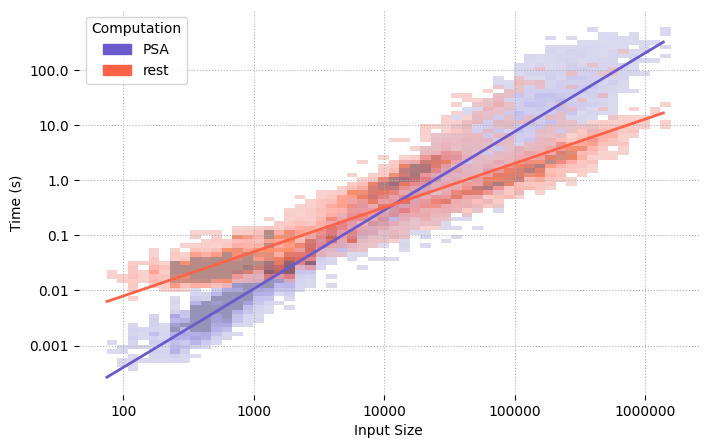

In [14]:
from sklearn.linear_model import LinearRegression

colors = [sn.color_palette("mako")[i] for i in [1, 3]]
colors = ["slateblue", "darkolivegreen"]

x_log = np.log10(plot_df["Input Size"])
y_log = np.log10(plot_df["Time (s)"])

plt.figure(figsize=(8, 5))
ax = sn.histplot(
    x=x_log,
    y=y_log,
    hue=plot_df["Computation"],
    palette=["slateblue", "tomato"],
    binwidth=0.08,
    alpha=0.6,
    common_norm=False,
    pthresh=0,
    pmax=0.7,
)
log_xticks = np.arange(2, 7)
log_yticks = np.arange(-3, 3)

plt.xlabel("Input Size")
plt.ylabel("Time (s)")
plt.xticks(log_xticks, labels=10**log_xticks)
plt.yticks(log_yticks, labels=10.0**log_yticks)

ax.grid(linestyle=":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

sn.move_legend(ax, "upper left")

colors = ["slateblue", "tomato"]
for i, computation in enumerate(plot_df["Computation"].unique()):
    mask = plot_df["Computation"] == computation
    x_vals = x_log[mask].to_numpy().reshape(-1, 1)
    y_vals = y_log[mask].to_numpy()
    model = LinearRegression().fit(x_vals, y_vals)
    x_fit = np.linspace(x_vals.min(), x_vals.max(), 100).reshape(-1, 1)
    y_fit = model.predict(x_fit)
    ax.plot(x_fit.flatten(), y_fit, color=colors[i], lw=2, label=f"{computation} fit")


plt.savefig(
    ROOT.parent / "figures" / "computation_psa_vs_rest.svg", bbox_inches="tight"
)

## Sample 84 datasets of different sizes

In [2]:
plot_df = perf_df.sum(axis=1).to_frame()
plot_df.columns = ["Time (s)"]
plot_df["Count"] = feat_df["num_seqs"].loc[plot_df.index]
plot_df["Length"] = feat_df["max.seq_length"].loc[plot_df.index]
plot_df["Input Size"] = plot_df["Count"] * plot_df["Length"]
strat_col = pd.cut(
    plot_df["Input Size"],
    bins=[
        0,
        1000,
        2500,
        5000,
        10000,
        25000,
        50000,
        100000,
        250000,
        500000,
        750000,
        1000000,
        1500000,
    ],
)
sample = plot_df.groupby(strat_col, observed=True).sample(n=7).reset_index().iloc[:, :2]
print(sample.shape)
sample.to_parquet(ROOT.parent / "logs" / "misc" / "runtime_sample.parquet")

path = Path("/hits/fast/cme/bodynems/data/paper") / sample.iat[0, 0] / sample.iat[0, 1]
print(os.listdir(path))
print(os.listdir(path / "se"))

NameError: name 'perf_df' is not defined

In [62]:
data_dir = Path("/hits/fast/cme/bodynems/data/benchmarking")
sample = pd.read_parquet(ROOT.parent / "logs" / "misc" / "runtime_sample.parquet")

perf_dict = {}
for i in range(len(sample)):
    source, dataset = sample.iloc[i, :]
    # os.makedirs(OUT_DIR / source / dataset / "ensemble")
    in_file = data_dir / source / dataset
    for handle in os.listdir(in_file):
        if os.path.isdir(in_file / handle) and not handle == "ensemble":
            bench_file = in_file / handle / "bench_ensemble.txt"
            if os.path.exists(bench_file):
                tool = bench_file.parent.name
                line = open(bench_file).readlines()[1]
                cpu_time = float(line.split("\t")[-1])
                perf_dict[(source, dataset, tool)] = cpu_time
            # else:
            #     print("[NOT DONE]", source, dataset)

In [66]:
from itertools import product

perf_df = pd.DataFrame(
    perf_dict.values(),
    index=perf_dict.keys(),
    columns=["Time (s)"],
).sort_index()

perf_df.index.names = ["source", "dataset", "tool"]
timeouts = (
    6
    - perf_df[["Time (s)"]]
    .reset_index()
    .drop(["tool"], axis=1)
    .groupby(["source", "dataset"])
    .count()
)
print(timeouts.mean())
print(perf_df.head())

perf_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time_detailed.parquet")
summary_df = (
    perf_df.reset_index().drop("tool", axis=1).groupby(["source", "dataset"]).sum()
)

# timeouts = timeouts.loc[perf_df.index]

# perf_df = perf_df + timeouts * 3600
summary_df.to_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
summary_df.describe()

Time (s)    0.202381
dtype: float64
                                  Time (s)
source    dataset tool                    
arthropod CYP_20  ClustalO           33.19
                  MAFFT_FFT-NS-2      5.71
                  MAFFT_G-INS-i      13.14
                  MAFFT_L-INS-i      13.05
                  Muscle3             9.75


,Time (s)
count,84.000000
mean,1326.133690
std,3943.727591
min,32.720000
25%,64.425000
50%,100.460000
75%,208.740000
max,24688.260000


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

perf_e = pd.read_parquet(ROOT.parent / "logs" / "misc" / "ensemble_time.parquet")
perf_h = pd.read_parquet(ROOT.parent / "logs" / "misc" / "heuristic_time.parquet")
perf_p = pd.read_parquet(ROOT.parent / "logs" / "misc" / "prediction_time.parquet")
idxs = perf_p.index

perf_h.sort_values("Time (s)", ascending=False)

perf_df = pd.concat([perf_e, perf_h, perf_p], join="inner", axis=1)
# perf_df = perf_df.fillna(perf_df.max(axis=0), axis=0)
print(perf_df.shape, "\n", perf_df.isna().mean())
perf_df = perf_df.fillna(3600, axis=0)
perf_df.columns = ["ensemble", "heuristic", "predict"]

perf_df = pd.concat([perf_df, feat_df], join="inner", axis=1)
perf_df["Input Size"] = perf_df["num_seqs"] * perf_df["max.seq_length"]
perf_df["bin"] = pd.cut(
    perf_df["Input Size"],
    bins=[0, 5000, 10000, 50000, 100000, 500000, 1500000],
)
perf_df.to_parquet(ROOT.parent / "logs" / "misc" / "runtimes.parquet")

(84, 3) 
 Time (s)    0.0
Time (s)    0.0
Time (s)    0.0
dtype: float64


ensemble  heuristic    predict  \
source        dataset                                                        
arthropod     CYP_20                          156.56   4.541023   8.952682   
              CYP_307                        1885.83  22.935572  20.544822   
bali3         BBS12037                         80.77   2.511588   7.270550   
              BBS20040                        124.17   8.601477   9.367815   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1     41.19   3.118539   6.610344   
...                                              ...        ...        ...   
treebase_v1   26800_3.phy                     114.60   5.085935   5.675323   
              27350_0.phy                     839.85   9.889267  13.591193   
              27596_39.phy                    102.08  24.190754  19.139840   
              28078_1.phy                    2807.76   8.539839  14.163398   
              28099_0.phy                      92.54   6.509556  13.082935   

                                            is_dna  num_seqs  max.seq_length  \
source        dataset                                                          
arthropod     CYP_20                         False        19             494   
              CYP_307                        False       121             642   
bali3         BBS12037                       False        13             509   
              BBS20040                       False        87             338   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1    True        15              84   
...                                            ...       ...             ...   
treebase_v1   26800_3.phy                     True        46             448   
              27350_0.phy                     True        59             971   
              27596_39.phy                    True        75            1764   
              28078_1.phy                     True        54             971   
              28099_0.phy                     True        33            1713   

                                            Input Size               bin  
source        dataset                                                     
arthropod     CYP_20                              9386     (5000, 10000]  
              CYP_307                            77682   (50000, 100000]  
bali3         BBS12037                            6617     (5000, 10000]  
              BBS20040                           29406    (10000, 50000]  
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1        1260         (0, 5000]  
...                                                ...               ...  
treebase_v1   26800_3.phy                        20608    (10000, 50000]  
              27350_0.phy                        57289   (50000, 100000]  
              27596_39.phy                      132300  (100000, 500000]  
              28078_1.phy                        52434   (50000, 100000]  
              28099_0.phy                        56529   (50000, 100000]  

[84 rows x 8 columns]

In [61]:
perf_df

ensemble  heuristic    predict  \
source        dataset                                                        
arthropod     CYP_20                           84.46   4.541023   8.952682   
              CYP_307                        5425.04  22.935572  20.544822   
bali3         BBS12037                         80.77   2.511588   7.270550   
              BBS20040                        124.17   8.601477   9.367815   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1     41.19   3.118539   6.610344   
...                                              ...        ...        ...   
treebase_v1   26800_3.phy                     114.60   5.085935   5.675323   
              27350_0.phy                     807.46   9.889267  13.591193   
              27596_39.phy                    102.08  24.190754  19.139840   
              28078_1.phy                    2807.76   8.539839  14.163398   
              28099_0.phy                      92.54   6.509556  13.082935   

                                            is_dna  num_seqs  max.seq_length  \
source        dataset                                                          
arthropod     CYP_20                         False        19             494   
              CYP_307                        False       121             642   
bali3         BBS12037                       False        13             509   
              BBS20040                       False        87             338   
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1    True        15              84   
...                                            ...       ...             ...   
treebase_v1   26800_3.phy                     True        46             448   
              27350_0.phy                     True        59             971   
              27596_39.phy                    True        75            1764   
              28078_1.phy                     True        54             971   
              28099_0.phy                     True        33            1713   

                                            Input Size               bin  
source        dataset                                                     
arthropod     CYP_20                              9386     (5000, 10000]  
              CYP_307                            77682   (50000, 100000]  
bali3         BBS12037                            6617     (5000, 10000]  
              BBS20040                           29406    (10000, 50000]  
bralibase_k15 HIV_GSL3.apsi-89.sci-66.no-1        1260         (0, 5000]  
...                                                ...               ...  
treebase_v1   26800_3.phy                        20608    (10000, 50000]  
              27350_0.phy                        57289   (50000, 100000]  
              27596_39.phy                      132300  (100000, 500000]  
              28078_1.phy                        52434   (50000, 100000]  
              28099_0.phy                        56529   (50000, 100000]  

[90 rows x 8 columns]

\begin{tabular}{lrrr}
\toprule
 & min & mean & max \\
\midrule
0 & 4.70 & 219.26 & 1011.12 \\
\bottomrule
\end{tabular}



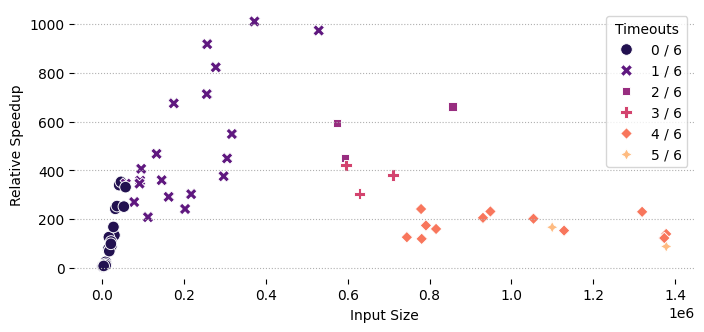

In [96]:
import matplotlib.ticker as mtick

speedup = (perf_df["ensemble"] + perf_df["heuristic"]) / perf_df["predict"]

print(
    speedup.aggregate(["min", "mean", "max"]).to_frame().T.to_latex(float_format="%.2f")
)

timeout_share = ((timeouts).iloc[:, 0]).astype(int)
plt.figure(figsize=(8, 3.5))
ax = sn.scatterplot(
    perf_df,
    x="Input Size",
    y=speedup,
    # hue=timeouts.iloc[:, 0].rename("Timeouts"),
    # style=timeouts.iloc[:, 0].rename("Timeouts"),
    hue=timeout_share,
    style=timeout_share,
    palette=sn.color_palette("magma", 6),
    s=70,
)
ax.grid(linestyle=":", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("Input Size")
ax.set_ylabel("Relative Speedup")
# plt.legend(title="Timeouts")

handles, labels = ax.get_legend_handles_labels()
# Convert integer class labels to integers (if they are not already)
int_labels = [int(l) for l in labels]

percentage_labels = [f"{x} / 6" for x in int_labels]

# Sort by the integer value to preserve order
sorted_items = sorted(zip(int_labels, handles, percentage_labels), key=lambda t: t[0])
sorted_handles = [t[1] for t in sorted_items]
sorted_labels = [t[2] for t in sorted_items]

plt.legend(sorted_handles, sorted_labels, title="Timeouts")

plt.savefig(ROOT.parent / "figures" / "runtime_speedup.svg", bbox_inches="tight")

# ax = sn.barplot(
#     perf_df,
#     x="bin",
#     y=speedup,
#     hue="bin",
#     zorder=2,
#     palette=sn.color_palette("mako", 6),
#     # palette=sn.cubehelix_palette(11),
#     alpha=0.75,
# )
# plt.yscale("log")
# iqr = lambda s: np.percentile(s, 75) - np.percentile(s, 25)
# speedup.groupby(perf_df["bin"]).agg(["mean", "std"]).T.round(2)

In [78]:
perf_df = perf_df.melt(
    id_vars=list(feat_df.columns) + ["bin", "Input Size"],
    value_vars=["ensemble", "heuristic", "predict"],
    var_name="Aspect",
    value_name="Time (s)",
)

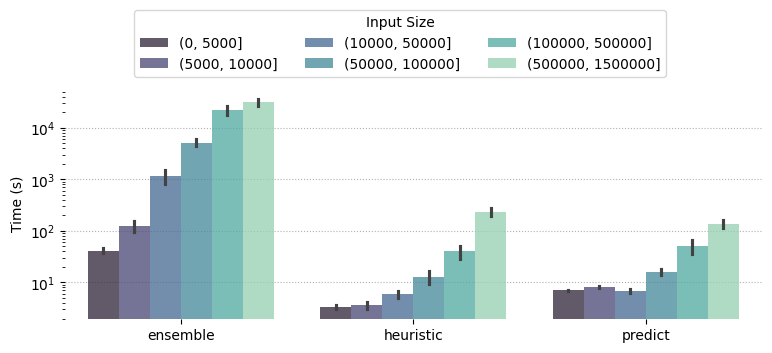

In [79]:
plt.figure(figsize=(9, 3))
ax = sn.barplot(
    perf_df,
    x="Aspect",
    y="Time (s)",
    hue="bin",
    zorder=2,
    palette=sn.color_palette("mako", 6),
    # palette=sn.cubehelix_palette(11),
    alpha=0.75,
)
plt.yscale("log")

ax.grid(linestyle=":", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
sn.move_legend(ax, loc=(0.1, 1.05), ncol=3, title="Input Size")

plt.savefig(ROOT.parent / "figures" / "runtime_comparison.svg", bbox_inches="tight")